In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install datasets
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [66]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [67]:
# Load the emotion dataset which contains the twitter dataset labelled as emotions.
dataset = load_dataset("dair-ai/emotion","split", trust_remote_code=True)

# Display the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [68]:
# Convert to pandas DataFrame
df_train = dataset['train'].to_pandas()
df_valid = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

In [69]:
print(df_train)

                                                    text  label
0                                i didnt feel humiliated      0
1      i can go from feeling so hopeless to so damned...      0
2       im grabbing a minute to post i feel greedy wrong      3
3      i am ever feeling nostalgic about the fireplac...      2
4                                   i am feeling grouchy      3
...                                                  ...    ...
15995  i just had a very brief time in the beanbag an...      0
15996  i am now turning and i feel pathetic that i am...      0
15997                     i feel strong and good overall      1
15998  i feel like this was such a rude comment and i...      3
15999  i know a lot but i feel so stupid because i ca...      0

[16000 rows x 2 columns]


In [70]:
print(df_valid)

                                                   text  label
0     im feeling quite sad and sorry for myself but ...      0
1     i feel like i am still looking at a blank canv...      0
2                        i feel like a faithful servant      2
3                     i am just feeling cranky and blue      3
4     i can have for a treat or if i am feeling festive      1
...                                                 ...    ...
1995  im having ssa examination tomorrow in the morn...      0
1996  i constantly worry about their fight against n...      1
1997  i feel its important to share this info for th...      1
1998  i truly feel that if you are passionate enough...      1
1999  i feel like i just wanna buy any cute make up ...      1

[2000 rows x 2 columns]


In [71]:
print(df_test)

                                                   text  label
0     im feeling rather rotten so im not very ambiti...      0
1             im updating my blog because i feel shitty      0
2     i never make her separate from me because i do...      0
3     i left with my bouquet of red and yellow tulip...      1
4       i was feeling a little vain when i did this one      0
...                                                 ...    ...
1995  i just keep feeling like someone is being unki...      3
1996  im feeling a little cranky negative after this...      3
1997  i feel that i am useful to my people and that ...      1
1998  im feeling more comfortable with derby i feel ...      1
1999  i feel all weird when i have to meet w people ...      4

[2000 rows x 2 columns]


In [72]:
# Display the original size of the training data
print(f"Original training data size: {len(df_train)}")

Original training data size: 16000


In [73]:
half_test_data = df_test.iloc[1000:]
test_data = df_test.iloc[:1000]

val_data = df_valid

print("new Vald data :",val_data.shape)
print("new Test data :",test_data.shape)

new Vald data : (2000, 2)
new Test data : (1000, 2)


In [74]:
df_train.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [75]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df_train['label_name'] = df_train['label'].map(labels_dict)
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [76]:
df_train.groupby(["label_name","label"]).size()

,,0
label_name,label,
anger,3,2159
fear,4,1937
joy,1,5362
love,2,1304
sadness,0,4666
surprise,5,572


<Axes: xlabel='label_name'>

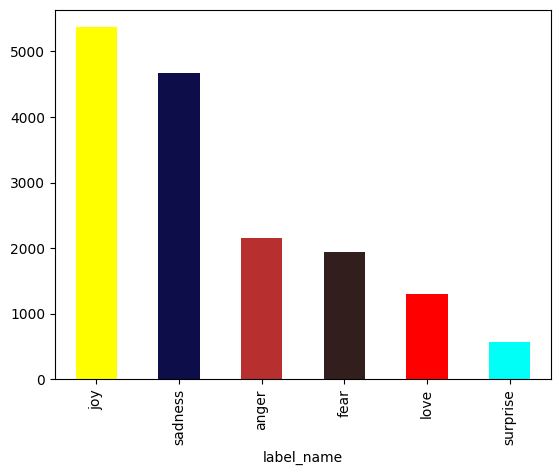

In [77]:
df_train["label_name"].value_counts().plot(kind='bar',color=['yellow', '#0c0d49', '#b82f2f', '#331e1e', 'red','#00fff7'])

In [78]:
print(df_train.isnull().sum())
print(df_valid.isnull().sum())
print(df_test.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [79]:
all_list = df_train['text'].tolist() + df_test['text'].tolist() + df_valid['text'].tolist()

In [80]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index

print("Numbre of words without Stemming:",len(word_index1))

Numbre of words without Stemming: 17096


In [81]:
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

print("Nombre of words with Stemming:",len(word_index2))

Nombre of words with Stemming: 11705


In [82]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']])
    return new_data

In [83]:
new_train_data = preprocess_data(df_train)
print(df_train['text'][0])
print(new_train_data[0])

i didnt feel humiliated
[[3198, 3265, 220, 665], 0]


In [84]:
new_val_data = preprocess_data(df_valid)
print(df_valid['text'][0])
print(new_val_data[0])

im feeling quite sad and sorry for myself but ill snap out of it soon
[[3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380], 0]


In [85]:
# Splitting into train_X and train_y
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]

# Print the results
print("train_X:", train_X[0])
print("train_y:", train_y[0])

train_X: [3198, 3265, 220, 665]
train_y: 0


In [86]:
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]

print("train_X:", val_X[0])
print("train_y:", val_y[0])

train_X: [3205, 220, 595, 1335, 3199, 3326, 3206, 3227, 3207, 1326, 518, 1283, 1274, 1276, 3380]
train_y: 0


In [87]:
length_of_longest_sentence = len(max(train_X, key=len))
print(length_of_longest_sentence)
print(max(train_X, key=len))

66
[3198, 613, 3250, 3588, 3217, 3204, 3198, 927, 3245, 1497, 3245, 1354, 3217, 3245, 1303, 1296, 3200, 2107, 1284, 1276, 3220, 220, 3598, 3213, 220, 1276, 3528, 3217, 7890, 4263, 3221, 5569, 1552, 3243, 3198, 4263, 3221, 1552, 5570, 5570, 3198, 3579, 5569, 3198, 7891, 1276, 3200, 3202, 1293, 3219, 1401, 3948, 3598, 3213, 3223, 239, 3528, 3213, 85, 3267, 579, 1658, 3206, 3201, 239, 1289]


In [88]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)

for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [89]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)

print(train_X.shape,train_y.shape)
print(val_X.shape,val_y.shape)

(16000, 66) (16000,)
(2000, 66) (2000,)


In [90]:
# Convert labels to one-hot encoding
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

In [91]:
"""model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))
#print model.summary()
print(model)"""

"model = Sequential()\nmodel.add(Embedding(16000, 100, input_length=66))\nmodel.add(Bidirectional(LSTM(150)))\nmodel.add(Dense(16000, activation='softmax'))\nadam = tf.keras.optimizers.Adam(learning_rate=0.01)\nmodel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])\nhistory = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot))\n#print model.summary()\nprint(model)"

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf

In [97]:
# Reduce dataset size for quicker training (optional)
df_train = df_train.sample(5000, random_state=42)
val_data = val_data.sample(1000, random_state=42)
test_data = test_data.sample(1000, random_state=42)

In [98]:
# Load tokenizer and tokenize the texts
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf')

train_encodings = tokenize_function(list(df_train['text']))
val_encodings = tokenize_function(list(val_data['text']))
test_encodings = tokenize_function(list(test_data['text']))

train_labels = tf.convert_to_tensor(df_train['label'].values)
val_labels = tf.convert_to_tensor(val_data['label'].values)
test_labels = tf.convert_to_tensor(test_data['label'].values)

# Load the pre-trained model
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

# Compile the model
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

# Train the model
history = model.fit(
    dict(train_encodings),
    train_labels,
    validation_data=(dict(val_encodings), val_labels),
    epochs=3,
    batch_size=16
)

# Evaluate the model
results = model.evaluate(dict(test_encodings), test_labels)
print("Test results:", results)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
313/313 [==============================] - 2627s 8s/step - loss: 6.4791 - accuracy: 0.2732 - val_loss: 6.9308 - val_accuracy: 0.2660
Epoch 2/3
313/313 [==============================] - 2613s 8s/step - loss: 6.7858 - accuracy: 0.2894 - val_loss: 6.9308 - val_accuracy: 0.2660
Epoch 3/3
32/32 [==============================] - 106s 3s/step - loss: 6.6246 - accuracy: 0.2950
Test results: [6.624606609344482, 0.29499998688697815]
